# Numerical Gradient
---
This notebook analyses the pixelwise gradient

In [1]:
import numpy as np
import pynoisy
import xarray as xr

import matplotlib.pyplot as plt
from pynoisy.inverse import ForwardOperator,ObjectiveFunction
from tqdm.notebook import tqdm

n_jobs = 4

In [2]:
def compute_gradient_ij(i, j, solver, forward, adjoint, dx=1e-8):
    spatial_angle = solver.diffusion.spatial_angle.copy()
    source = solver.get_laplacian(forward)
    solver.diffusion.spatial_angle[i, j] = spatial_angle[i, j] + dx
    source_ij = solver.get_laplacian(forward) - source
    solver.diffusion.spatial_angle[i, j] = spatial_angle[i, j]
    source_ij = source_ij / dx
    gradient = (adjoint * source_ij).sum()
    return gradient

def compute_gradient1(idx, jdx, solver, forward, adjoint, dx=1e-8):
    spatial_angle = solver.diffusion.spatial_angle.copy()
    source = solver.get_laplacian(forward)
    gradient = np.zeros(shape=spatial_angle.shape)
    for i in range(gradient.shape[0]):
        for j in range(gradient.shape[1]):
            if ((idx == i) and (jdx == j)): 
                solver.diffusion.spatial_angle[i, j] = spatial_angle[i, j] + dx
                source_ij = solver.get_laplacian(forward) - source
                solver.diffusion.spatial_angle[i, j] = spatial_angle[i, j]
                source_ij = source_ij / dx
                gradient[i,j] = (adjoint * source_ij).sum()
    return xr.DataArray(data=gradient, coords=solver.params.coords, attrs={'grad_type': 'loop'})

def compute_gradient(solver, forward, adjoint, dx=1e-8):
    spatial_angle = solver.diffusion.spatial_angle.copy()
    source = solver.get_laplacian(forward)
    gradient = np.zeros(shape=spatial_angle.shape)
    for i in tqdm(range(gradient.shape[0]), desc='i loop'):
        for j in tqdm(range(gradient.shape[1]), desc='j loop', leave=False):
            solver.diffusion.spatial_angle[i, j] = spatial_angle[i, j] + dx
            source_ij = solver.get_laplacian(forward) - source
            solver.diffusion.spatial_angle[i, j] = spatial_angle[i, j]
            source_ij = source_ij / dx
            gradient[i,j] = (adjoint * source_ij).sum()
        if i>3:
            break
    return xr.DataArray(data=gradient, coords=solver.params.coords, attrs={'grad_type': 'loop'})

## Generate measurements

In [5]:
advection_true = pynoisy.advection.general_xy(64, 64)
diffusion_true = pynoisy.diffusion.general_xy(64, 64)
solver = pynoisy.forward.HGRFSolver(64, 64, advection_true, diffusion_true, seed=123)
measurements = solver.run(num_frames=64, n_jobs=n_jobs)
measurements.to_netcdf('meas.nc')
solver.save('solver.nc')

## L2 Non-krylov

### Generate gradient

In [5]:
solver = pynoisy.forward.HGRFSolver.from_netcdf('solver.nc')
measurements = xr.load_dataarray('meas.nc')
adjoint_fn = lambda source: solver.run(source=source, n_jobs=n_jobs)
forward_fn = lambda: solver.run(num_frames=measurements.sizes['t'], n_jobs=n_jobs)
gradient_fn = None
get_state_fn = pynoisy.inverse.spatial_angle_get_state(solver)
set_state_fn = pynoisy.inverse.spatial_angle_set_state(solver)
forward_op = ForwardOperator(
    forward_fn=forward_fn,
    adjoint_fn=adjoint_fn,
    gradient_fn=gradient_fn,
    set_state_fn=set_state_fn,
    get_state_fn=get_state_fn,
)

state = np.zeros(shape=solver.diffusion.spatial_angle.size)
synthetic_movie = forward_op(state.ravel())
error = synthetic_movie - measurements
loss = (error ** 2).mean()
adjoint = forward_op.adjoint(error)
gradient = compute_gradient(solver, synthetic_movie, adjoint)

synthetic_movie.to_netcdf('syn.nc')
error.to_netcdf('error.nc')
adjoint.to_netcdf('adjoint.nc')
#gradient.to_netcdf('gradient.nc')

### Plots

In [ ]:
%matplotlib notebook
measurements.noisy_methods.get_animation(vmin=-1, vmax=1)

In [ ]:
%matplotlib notebook
synthetic_movie.noisy_methods.get_animation(vmin=-1, vmax=1)

In [ ]:
%matplotlib notebook
pynoisy.utils.compare_movie_frames(measurements, synthetic_movie)

### Single pixel

In [3]:
solver = pynoisy.forward.HGRFSolver.from_netcdf('solver.nc')
measurements = xr.load_dataarray('meas.nc')
synthetic_movie = xr.load_dataarray('syn.nc')
error = xr.load_dataarray('error.nc')
adjoint = xr.load_dataarray('adjoint.nc')

gradient_new = solver.get_spatial_angle_gradient(synthetic_movie, adjoint)

<IPython.core.display.Javascript object>


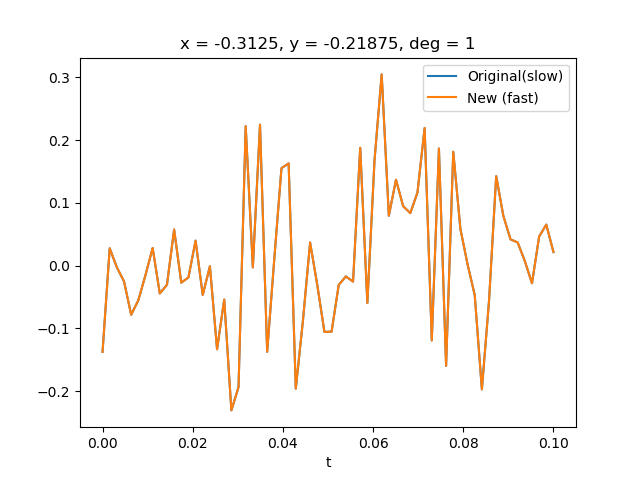

In [20]:
i = np.random.randint(0,65)
j = np.random.randint(0,65)
gradient = compute_gradient_ij(i, j, solver, synthetic_movie, adjoint, dx=1e-8)

%matplotlib notebook
gradient.sum(['x','y']).plot(label='Original(slow)')
gradient_new.isel(x=j, y=i).plot(label='New (fast)') 
plt.legend()

In [12]:
i = np.random.randint(0,64)
j = np.random.randint(0,64)
gradient = compute_gradient1(i, j, solver, synthetic_movie, adjoint, dx=1e-8)
print(gradient.isel(x=i, y=j).data, gradient_new.isel(x=i, y=j).data)

8.509518285198917 8.509518467614912


<IPython.core.display.Javascript object>


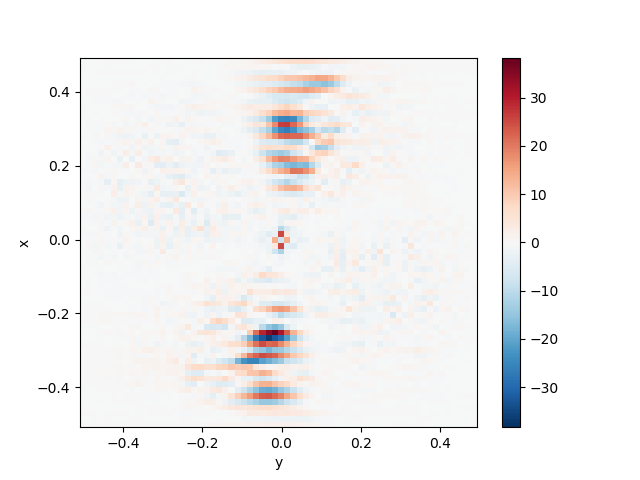

In [13]:
%matplotlib notebook
gradient_new.plot()

### Load and analyse

In [4]:
solver = pynoisy.forward.HGRFSolver.from_netcdf('solver.nc')
measurements = xr.load_dataarray('meas.nc')
gradient =  xr.load_dataarray('gradient.nc')
adjoint =  xr.load_dataarray('adjoint.nc')
synthetic_movie = xr.load_dataarray('syn.nc')
solver.diffusion.spatial_angle[:] = 0.0
gradient_new = solver.get_spatial_angle_gradient(synthetic_movie, adjoint)

<IPython.core.display.Javascript object>


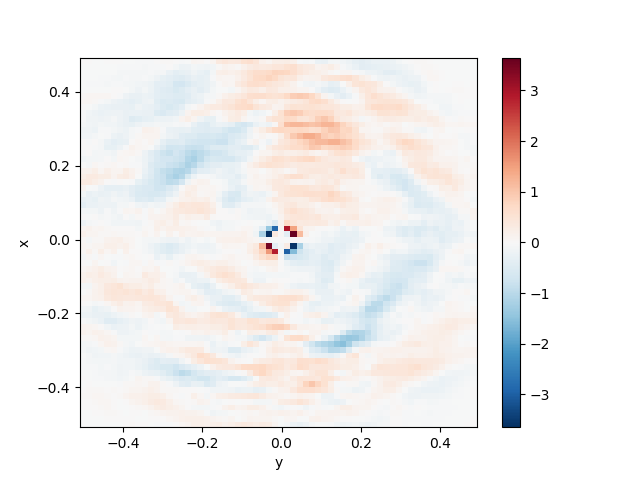

In [5]:
%matplotlib notebook
gradient.plot()

<IPython.core.display.Javascript object>


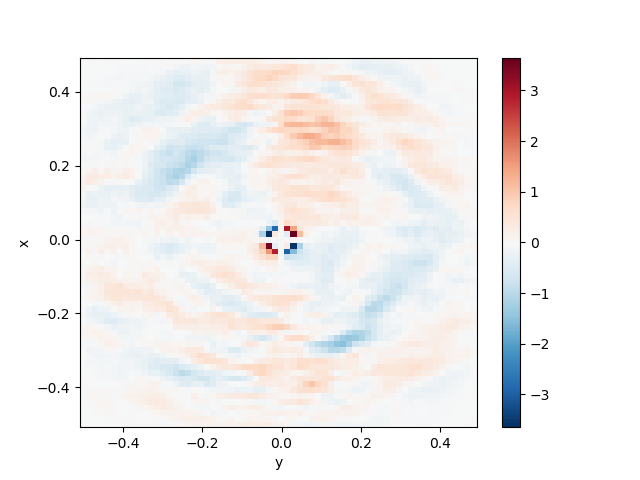

In [6]:
%matplotlib notebook
gradient_new = solver.get_spatial_angle_gradient(synthetic_movie, adjoint)
gradient_new.plot()

<IPython.core.display.Javascript object>


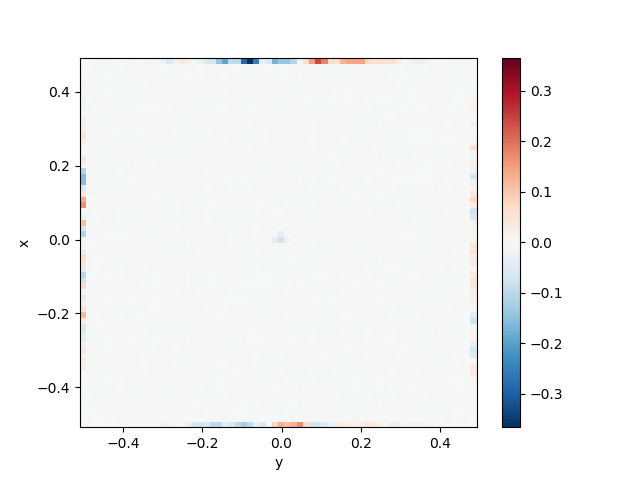

In [88]:
%matplotlib notebook
(gradient_new-gradient).plot()

## Krylov

### Generate gradient

In [146]:
solver = pynoisy.forward.HGRFSolver.from_netcdf('solver.nc')
measurements = xr.load_dataarray('meas.nc')

adjoint_fn = lambda source: solver.run(source=source, n_jobs=n_jobs)
forward_fn = lambda: solver.run(num_frames=64, n_jobs=n_jobs)
gradient_fn = None
get_state_fn = pynoisy.inverse.spatial_angle_get_state(solver)
set_state_fn = pynoisy.inverse.spatial_angle_set_state(solver)

forward_op = ForwardOperator(
    forward_fn=forward_fn,
    adjoint_fn=adjoint_fn,
    gradient_fn=gradient_fn,
    set_state_fn=set_state_fn,
    get_state_fn=get_state_fn
)

init_state = np.zeros(shape=solver.diffusion.spatial_angle.size)
forward_op.set_state(init_state)
synthetic_movie = forward_op(forward_op.get_state())
error = synthetic_movie - measurements
loss = (error ** 2).mean()
print(loss)
adjoint = forward_op.adjoint(error)
gradient = solver.get_spatial_angle_gradient(synthetic_movie, adjoint)

<xarray.DataArray ()>o: 123
array(0.00701984)
Coordinates:
    deg      int64 1


In [209]:
alpha = 0.7
x=init_state + alpha * gradient.data.ravel()
forward_op.set_state(x)
synthetic_movie = forward_op(forward_op.get_state())
error = synthetic_movie - measurements
loss = (error ** 2).mean()
print(loss)

<xarray.DataArray ()>
array(0.01354814)
Coordinates:
    deg      int64 1


In [153]:
import scipy.optimize

def f(x):
    forward_op.set_state(x)
    synthetic_movie = forward_op(forward_op.get_state())
    error = synthetic_movie - measurements
    loss = (error ** 2).mean()
    return np.array(loss)

def myfprime(x):
    forward_op.set_state(x)
    synthetic_movie = forward_op(forward_op.get_state())
    error = synthetic_movie - measurements
    adjoint = forward_op.adjoint(error)
    gradient = solver.get_spatial_angle_gradient(synthetic_movie, adjoint)
    return gradient.data.ravel()

res = scipy.optimize.line_search(f, myfprime, init_state, -gradient.data.ravel())

/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


In [3]:
solver = pynoisy.forward.HGRFSolver.from_netcdf('solver.nc')
measurements = xr.load_dataarray('meas.nc')


In [45]:
solver = pynoisy.forward.HGRFSolver.from_netcdf('solver.nc')
measurements = xr.load_dataarray('meas.nc')

mask = xr.ones_like(solver.diffusion.spatial_angle, dtype=np.bool)
#mask[0,:] = 0
#mask[:,0] = 0
#mask[-1,:] = 0
#mask[:,-1] = 0
mask[10,20:-20] = 0
solver.params['mask'] = mask
solver.params.attrs['num_unknowns'] = solver.params.mask.sum().data
initial_state = np.zeros(shape=solver.params.num_unknowns)

solver.diffusion.spatial_angle[:] = np.pi/2
adjoint_fn = lambda source: solver.run(source=source, n_jobs=n_jobs)
forward_fn = lambda: solver.run(num_frames=64, n_jobs=n_jobs)
gradient_fn = None
get_state_fn = pynoisy.inverse.spatial_angle_get_state(solver)
set_state_fn = pynoisy.inverse.spatial_angle_set_state(solver)
set_state_fn(initial_state)

In [54]:
import scipy.fftpack as fftpack

<IPython.core.display.Javascript object>


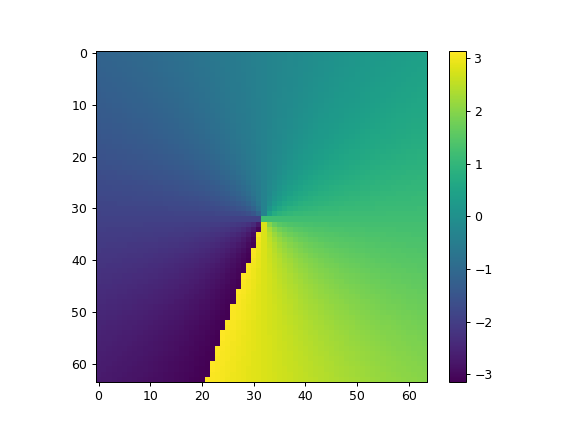

In [108]:
%matplotlib notebook
angle = np.exp(np.complex(0,1)*solver.diffusion.spatial_angle)
plt.imshow(np.angle(angle))
plt.colorbar()

<IPython.core.display.Javascript object>


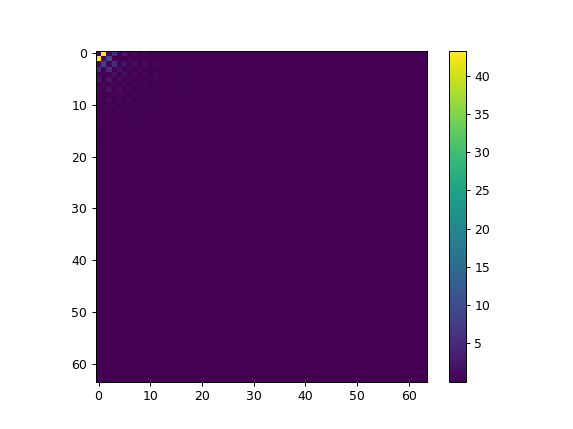

In [128]:
%matplotlib notebook



dct[2:] = 0
dct[:,2:] = 0

dct[:2,:2] = np.random.randn(2,2)

dct = fftpack.dctn(angle, norm='ortho')

plt.imshow(np.abs(dct))
plt.colorbar()

<IPython.core.display.Javascript object>


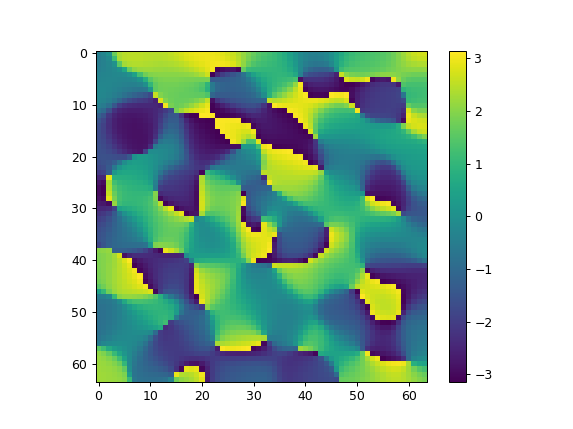

In [182]:
N = 10
dct[:N,:N] =  np.random.randn(N,N) + np.complex(0,1) * np.random.randn(N,N)

%matplotlib notebook
plt.imshow(np.angle(fftpack.idctn(dct, norm='ortho')))
plt.colorbar()

<IPython.core.display.Javascript object>


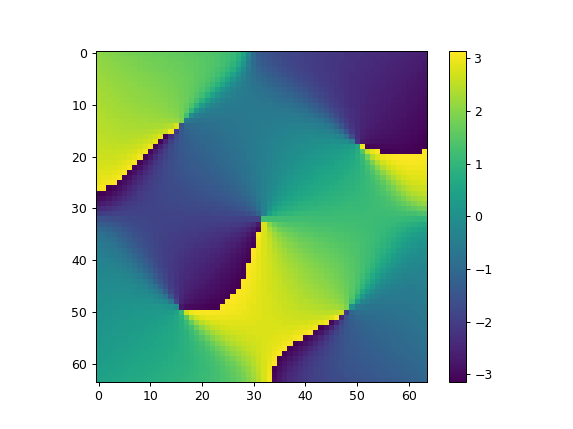

<IPython.core.display.Javascript object>


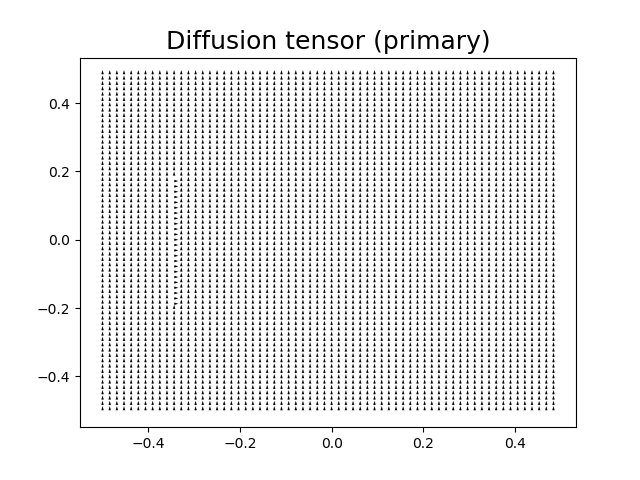

In [41]:
%matplotlib notebook
solver.diffusion.noisy_methods.plot_principal_axis(downscale_factor=1, mode='hgrf')

In [46]:
a = solver.run(num_frames=64, n_jobs=n_jobs, verbose=4, solver_id=0)

In [44]:
%matplotlib notebook
xr.load_dataset('../../inoisy/test.h5', group='data').data_raw

<xarray.DataArray 'data_raw' (phony_dim_0: 64)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Dimensions without coordinates: phony_dim_0, phony_dim_0, phony_dim_0

In [50]:
pixels = xr.load_dataset('../../inoisy/test.h5', group='data')
coords = {'t': np.linspace(0, 0.1, 64), 'x': solver.params.x, 'y': solver.params.y}
dims = ['t', 'x', 'y']

movie = xr.DataArray(data=pixels.data_raw.data, coords=coords, dims=dims)

<IPython.core.display.Javascript object>


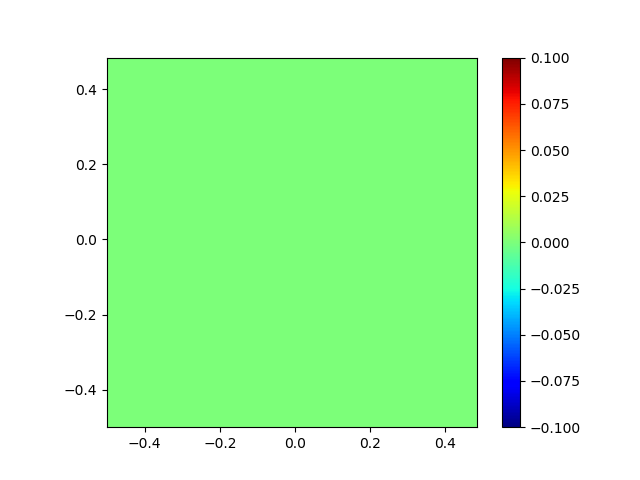

In [51]:
%matplotlib notebook
movie.noisy_methods.get_animation(cmap='jet')

<IPython.core.display.Javascript object>


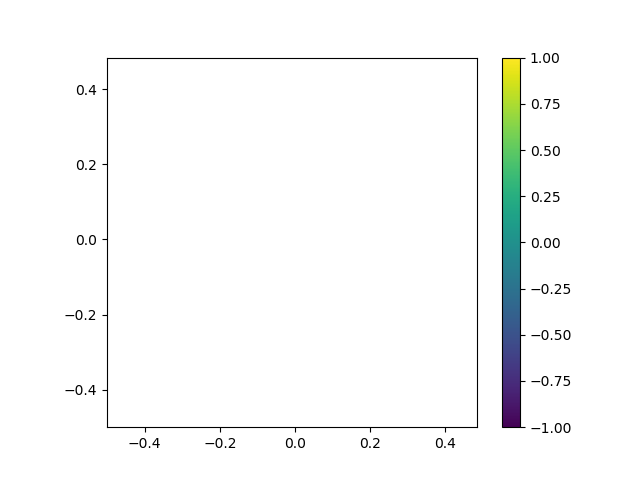

In [8]:
%matplotlib notebook
a.noisy_methods.get_animation(vmin=-1, vmax=1)

In [16]:
degree = 8
solver = pynoisy.forward.HGRFSolver.from_netcdf('solver.nc')
measurements = xr.load_dataarray('meas.nc')

forward_fn = lambda source: solver.run(source=source, n_jobs=n_jobs, std_scaling=False)
adjoint_fn = lambda source: solver.run(source=source, n_jobs=n_jobs, std_scaling=False)
# forward_fn = lambda: solver.run(num_frames=64, n_jobs=n_jobs)
gradient_fn = None
get_state_fn = pynoisy.inverse.spatial_angle_get_state(solver)
set_state_fn = pynoisy.inverse.spatial_angle_set_state(solver)
k_matrix_fn = lambda source, nrecur: solver.run(source=source, num_frames=64, n_jobs=n_jobs, nrecur=nrecur, std_scaling=False).data.reshape(nrecur, -1)

forward_op = ForwardOperator.krylov(
    forward_fn=forward_fn,
    adjoint_fn=adjoint_fn,
    gradient_fn=gradient_fn,
    set_state_fn=set_state_fn,
    get_state_fn=get_state_fn,
    measurements=measurements,
    degree=8,
    k_matrix_fn=k_matrix_fn
)

init_state = np.zeros(shape=solver.diffusion.spatial_angle.size)
#init_state = solver.diffusion.spatial_angle.data.ravel()
forward_op.set_state(init_state)
synthetic_movie = forward_op(forward_op.get_state())
error = synthetic_movie - measurements
loss = (error ** 2).mean()
print(loss)
adjoint = forward_op.adjoint(error) 
gradient = solver.get_spatial_angle_gradient(synthetic_movie, adjoint)

<xarray.DataArray ()>o: 123
array(0.00481833)
Coordinates:
    deg      int64 1


<IPython.core.display.Javascript object>


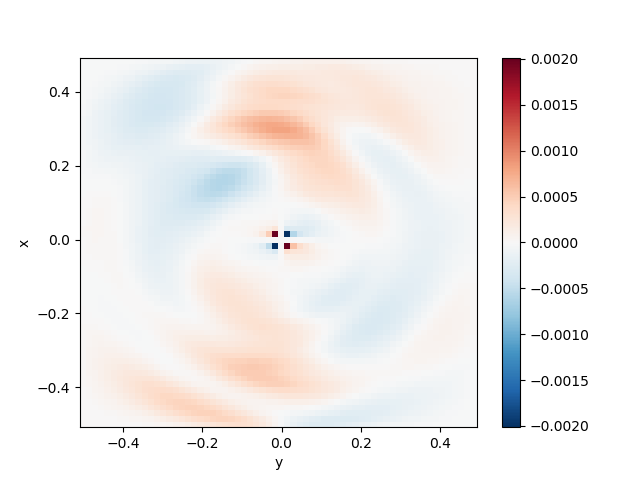

In [17]:
%matplotlib notebook
gradient.plot()

<IPython.core.display.Javascript object>


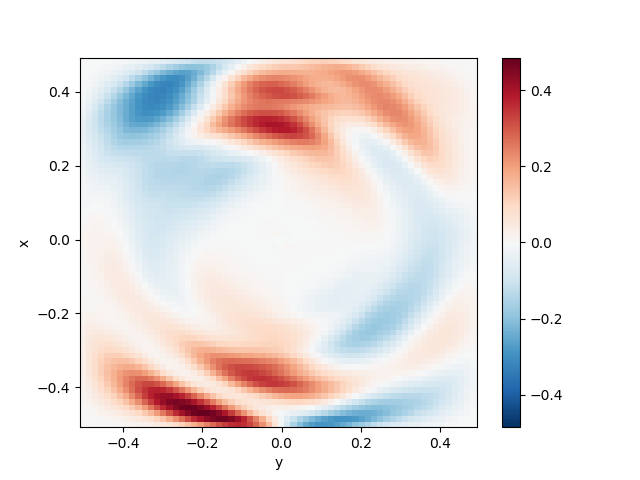

In [6]:
%matplotlib notebook
gradient.plot()

In [42]:
factor = (4. * np.pi) ** (3. / 2.) * gamma(2. * nrecur) / gamma(2. * nrecur - 3. / 2.)
scaling = np.sqrt(factor * solver.diffusion.tensor_ratio * solver.diffusion.correlation_time *
                  solver.diffusion.correlation_length ** 2).clip(min=1e-10)

<IPython.core.display.Javascript object>


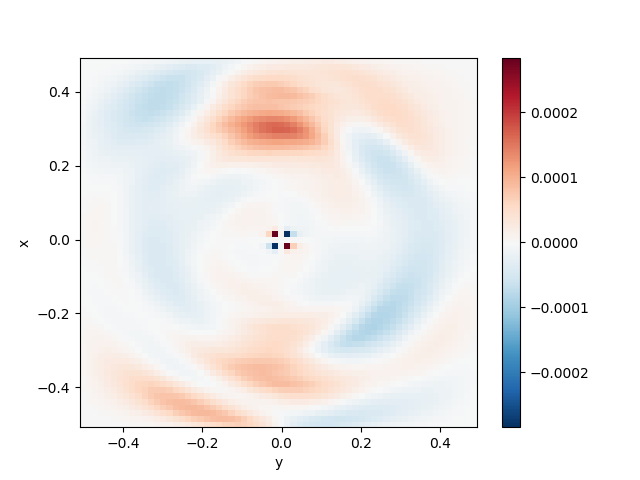

In [39]:
%matplotlib notebook
gradient.plot()

In [50]:
k_matrix.shape

(4, 262144)

In [49]:
k_matrix = pynoisy.utils.get_krylov_matrix(measurements, forward_fn, degree=4)

In [285]:
i=0
coords = {'t': np.linspace(0, 0.1, 64), 'x': solver.params.x, 'y': solver.params.y}
dims = ['t', 'x', 'y']
movie = xr.DataArray(data=k_matrix[i].reshape(64,64,64), coords=coords, dims=dims)

<IPython.core.display.Javascript object>


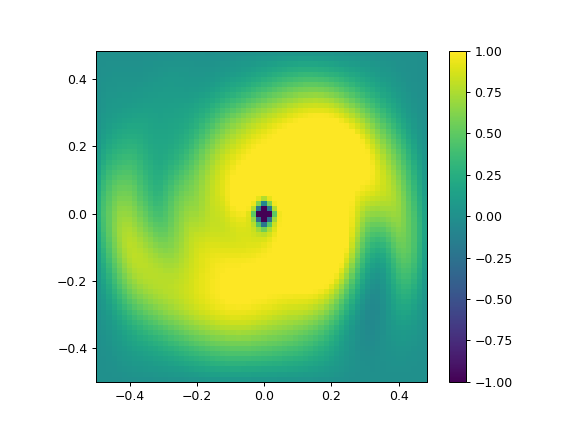

In [287]:
%matplotlib notebook
movie.noisy_methods.get_animation(vmin=-1, vmax=1)

In [237]:
forward_op.set_state(forward_op.get_state() - gradient.data.ravel())
synthetic_movie = forward_op(forward_op.get_state())
error = synthetic_movie - measurements
loss = (error ** 2).mean()
print(loss)
adjoint = forward_op.adjoint(error)
gradient = solver.get_spatial_angle_gradient(synthetic_movie, adjoint)

<xarray.DataArray ()>
array(0.00046046)
Coordinates:
    deg      int64 1


<IPython.core.display.Javascript object>


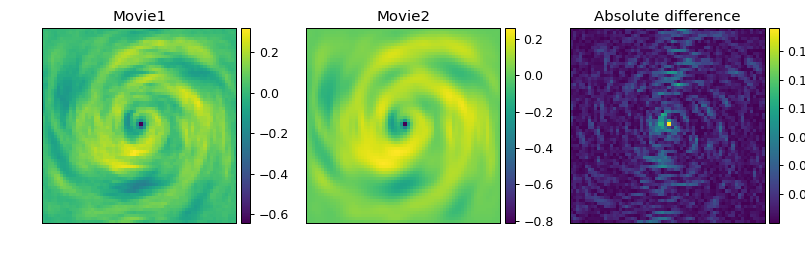

interactive(children=(IntSlider(value=31, description='i', max=63), Output()), _dom_classes=('widget-interact'…

In [274]:
pynoisy.utils.compare_movie_frames(measurements, synthetic_movie)

<IPython.core.display.Javascript object>


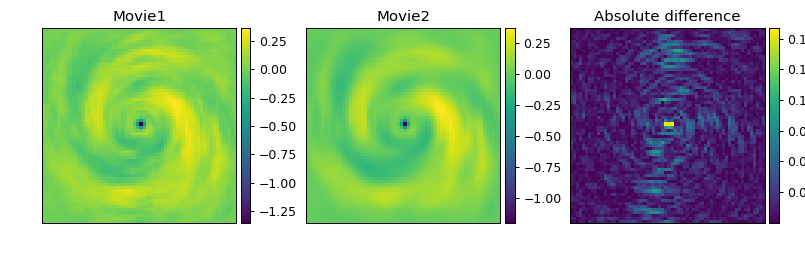

interactive(children=(IntSlider(value=31, description='i', max=63), Output()), _dom_classes=('widget-interact'…

In [245]:
pynoisy.utils.compare_movie_frames(measurements, synthetic_movie)

<IPython.core.display.Javascript object>


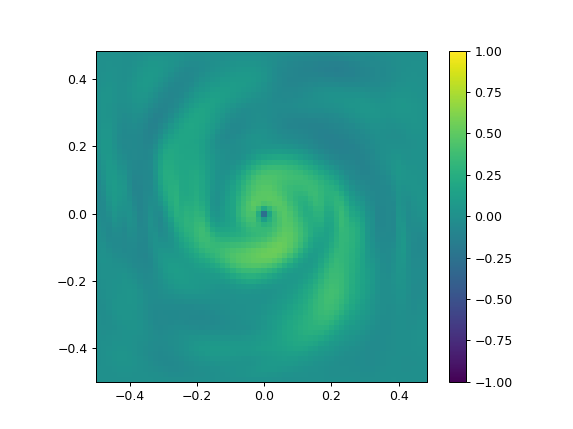

In [243]:
%matplotlib notebook
synthetic_movie.noisy_methods.get_animation(vmin=-1, vmax=1)

<IPython.core.display.Javascript object>


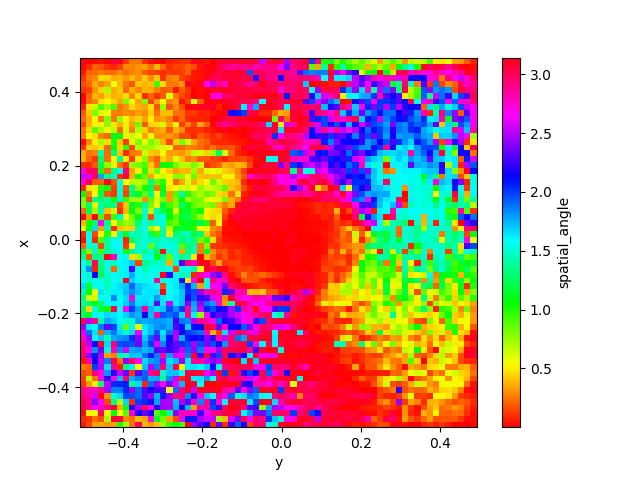

In [97]:
%matplotlib notebook
np.mod(solver.diffusion.spatial_angle, np.pi).plot(cmap='hsv')

<IPython.core.display.Javascript object>


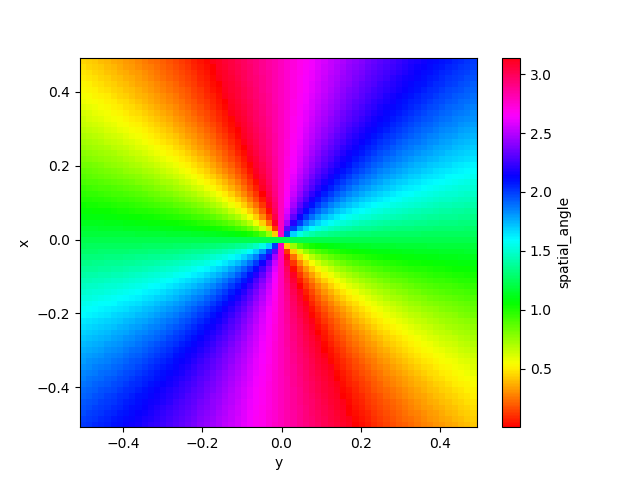

In [89]:
%matplotlib notebook
diffusion_true = pynoisy.diffusion.general_xy(64, 64)
np.mod(diffusion_true.spatial_angle, np.pi).plot(cmap='hsv')

In [22]:
forward_op.set_state(init_state - gradient.data.ravel())
synthetic_movie = forward_op(forward_op.get_state())
error = synthetic_movie - measurements
loss = (error ** 2).mean()
print(loss)

<xarray.DataArray ()>
array(0.00662304)
Coordinates:
    deg      int64 1


<IPython.core.display.Javascript object>


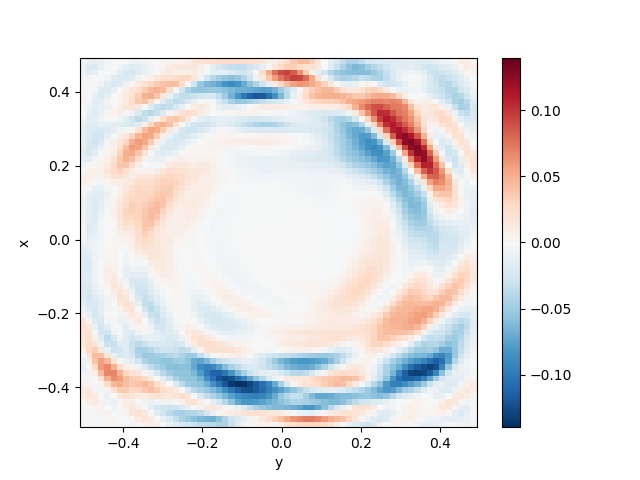

In [15]:
%matplotlib notebook
gradient.plot()

In [4]:
advection_true = pynoisy.advection.general_xy(64, 64)
diffusion_true = pynoisy.diffusion.general_xy(64, 64)
solver = pynoisy.forward.HGRFSolver(64, 64, advection_true, diffusion_true, seed=123)

from scipy.special import gamma
nrecur = 1
factor = (4. * np.pi) ** (3. / 2.) * gamma(2. * nrecur) / gamma(2. * nrecur - 3. / 2.)
scaling = np.sqrt(factor * solver.diffusion.tensor_ratio * solver.diffusion.correlation_time *
                  solver.diffusion.correlation_length ** 2).clip(min=1e-10)

meas = [solver.run(num_frames=64, n_jobs=n_jobs) * scaling]
#k = solver.run(num_frames=64, nrecur=8, n_jobs=n_jobs)

<IPython.core.display.Javascript object>


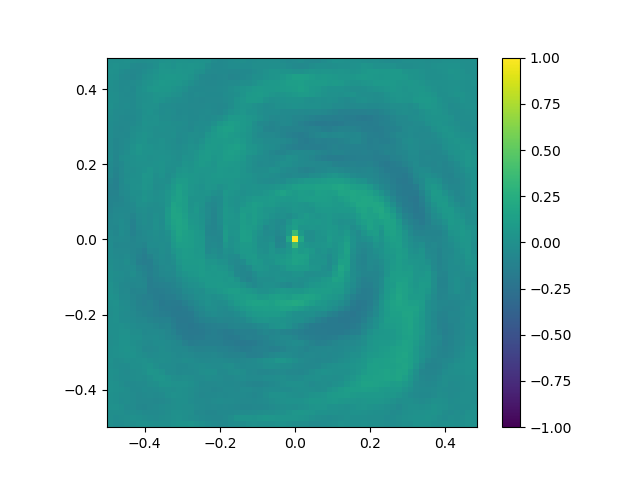

In [98]:
%matplotlib notebook
error.noisy_methods.get_animation(vmin=-1, vmax=1)

<IPython.core.display.Javascript object>


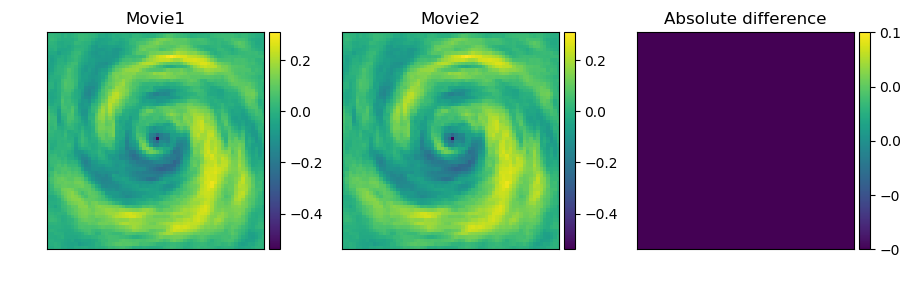

interactive(children=(IntSlider(value=31, description='i', max=63), Output()), _dom_classes=('widget-interact'…

In [21]:
pynoisy.utils.compare_movie_frames((meas*scaling), (k.sel(deg=1)*scaling))

<IPython.core.display.Javascript object>


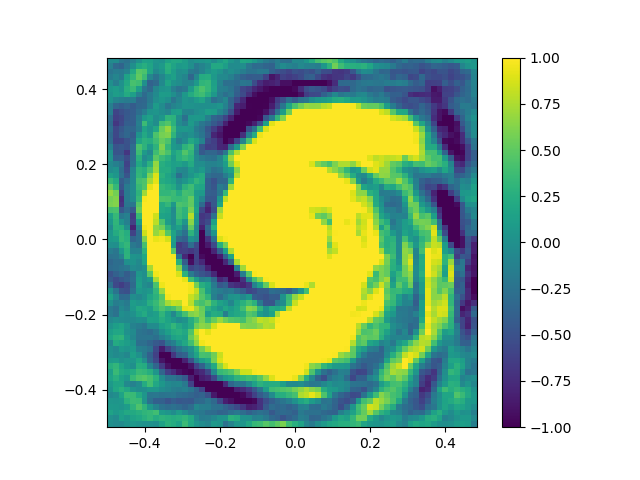

In [24]:
%matplotlib notebook
k.sel(deg=1).noisy_methods.get_animation(vmin=-1, vmax=1)

<IPython.core.display.Javascript object>


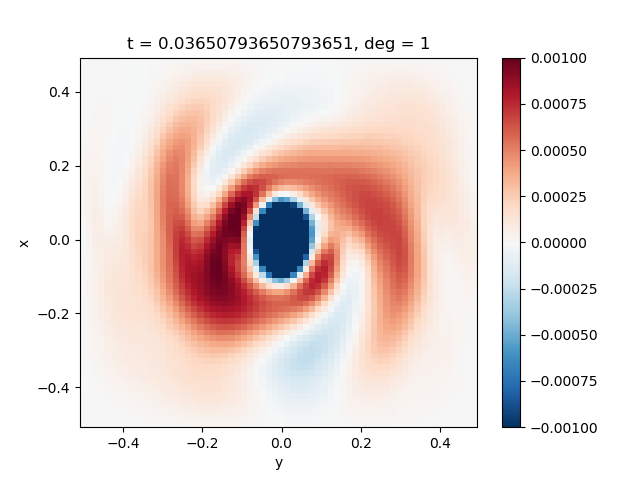

In [14]:
%matplotlib notebook
adjoint.clip(min=-0.001, max=0.001).isel(t=23).plot()

In [ ]:
degree = 8

adjoint_fn = lambda source: solver.run(source=source, n_jobs=n_jobs)
forward_fn = lambda: solver.run(num_frames=measurements.sizes['t'], n_jobs=n_jobs)
gradient_fn = None
get_state_fn = pynoisy.inverse.spatial_angle_get_state(solver)
set_state_fn = pynoisy.inverse.spatial_angle_set_state(solver)
k_matrix_fn = lambda source, degree: solver.run(source=source, nrecur=degree, n_jobs=n_jobs).data.reshape(degree, -1)
forward_op = ForwardOperator.krylov(
    forward_fn=forward_fn,
    adjoint_fn=adjoint_fn,
    gradient_fn=gradient_fn,
    set_state_fn=set_state_fn,
    get_state_fn=get_state_fn,
    measurements=measurements,
    degree=degree,
    k_matrix_fn=k_matrix_fn
)

state = np.zeros(shape=solver.diffusion.spatial_angle.size)
synthetic_movie = forward_op(state.ravel())
error = synthetic_movie - measurements
loss = (error ** 2).mean()
adjoint = forward_op.adjoint(error)
gradient = compute_gradient(solver, synthetic_movie, adjoint)

synthetic_movie.to_netcdf('syn_krylov.nc')
error.to_netcdf('error_krylov.nc')
adjoint.to_netcdf('adjoint_krylov.nc')
gradient.to_netcdf('gradient_krylov.nc')

### Load and analyse

In [ ]:
solver = pynoisy.forward.HGRFSolver.from_netcdf('solver.nc')
measurements = xr.load_dataarray('meas.nc')
synthetic_movie = xr.load_dataarray('syn_krylov.nc')
error = xr.load_dataarray('error_krylov.nc')
adjoint = xr.load_dataarray('adjoint_krylov.nc')
gradient = xr.load_dataarray('gradient_krylov.nc')

adjoint_fn = lambda source: solver.run(source=source, n_jobs=n_jobs)
forward_fn = lambda: solver.run(num_frames=measurements.sizes['t'], n_jobs=n_jobs)
gradient_fn = None
get_state_fn = pynoisy.inverse.spatial_angle_get_state(solver)
set_state_fn = pynoisy.inverse.spatial_angle_set_state(solver)
forward_op = ForwardOperator(
    forward_fn=forward_fn,
    adjoint_fn=adjoint_fn,
    gradient_fn=gradient_fn,
    set_state_fn=set_state_fn,
    get_state_fn=get_state_fn,
)

In [ ]:
solver.params['num_unknowns'] = int(solver.diffusion.spatial_angle.size)

In [ ]:
np.zeros(shape=solver.params.num_unknowns)

In [ ]:
%matplotlib notebook
(adjoint * solver.diffusion.correlation_length**2)

In [ ]:
%matplotlib notebook
gradient.clip(min=-1e-6, max=1e-6).plot()

In [ ]:
gradient1 = solver.get_spatial_angle_gradient(synthetic_movie, adjoint)

In [ ]:
%matplotlib notebook
gradient1.clip(min=-0.01, max=0.01).plot()

## DEBUG

In [ ]:
%matplotlib notebook
grad1.sum(['x','y']).plot(label='grad1')
grad2.sum(['x','y']).plot(label='grad2')
plt.legend()

In [ ]:
def compute_h(i, j):
    theta = solver.diffusion.spatial_angle[i, j].data
    vx = solver.advection.vx[i, j].data
    vy = solver.advection.vx[i, j].data
    u0 = [1.0, vy, vx]
    u1 = [0.0, np.cos(theta), np.sin(theta)]
    u2 = [0.0, -np.sin(theta), np.cos(theta)]
    lam0 = solver.diffusion.correlation_time[i, j].data
    lam1 = solver.diffusion.correlation_length[i, j].data
    lam2 = solver.diffusion.tensor_ratio.data * lam1
    h = np.empty((3,3))
    for i in range(3):
        for j in range(3):
            h[i,j] = lam0 * lam0 * u0[i] * u0[j] + \
                        lam1 * lam1 * u1[i] * u1[j] + \
                            lam2 * lam2 * u2[i] * u2[j]
    return h

def compute_dh(i, j, dx0, dx1, dx2):
    dx = [dx0, dx1, dx2]
    hp, hm, dh = np.empty((3,3,3)), np.empty((3,3,3)), np.empty((3,3,3))
    hp[0] = compute_h(i,j)
    hm[0] = compute_h(i,j)
    hp[1] = compute_h(i,j+1)
    hm[1] = compute_h(i,j-1)
    hp[2] = compute_h(i+1,j)
    hm[2] = compute_h(i-1,j)
    for ii in range(3):
        for jj in range(3):
            for kk in range(3):
                 dh[ii][jj][kk] = 0.5 * ( hp[kk][ii][jj] - hm[kk][ii][jj] ) / dx[kk]
    return dh    
    
def compute_coeff(i, j):
    dx2 = 20.0 / 64.0
    dx1 = dx2
    dx0 = 100.0 / 64.0
    h = compute_h(i,j)
    dh = compute_dh(i, j, dx0, dx1, dx2)
    coeff = np.empty((10,1))
    coeff[0] = -h[2][2] / (dx2 * dx2);
    coeff[1] = -0.5 * h[1][2] / (dx1 * dx2);
    coeff[2] = -h[1][1] / (dx1 * dx1);
    coeff[3] = -0.5 * h[0][2] / (dx0 * dx2);
    coeff[4] = -0.5 * h[0][1] / (dx0 * dx1);
    coeff[5] = -h[0][0] / (dx0 * dx0);
    coeff[6] = -0.5 * ( dh[0][2][0] + dh[1][2][1] + dh[2][2][2] ) / dx2;
    coeff[7] = -0.5 * ( dh[0][1][0] + dh[1][1][1] + dh[2][1][2] ) / dx1;
    coeff[8] = -0.5 * ( dh[0][0][0] + dh[1][0][1] + dh[2][0][2] ) / dx0;
    coeff[9] = -2. * ( coeff[0] + coeff[2] + coeff[5] ) + 1.0;  
    return coeff

In [ ]:
solver = pynoisy.forward.HGRFSolver.from_netcdf('solver.nc')
measurements = xr.load_dataarray('meas.nc')
synthetic_movie = measurements.copy()
adjoint = xr.ones_like(measurements)
adjoint.name='data_raw'
adjoint.to_netcdf('/tmp/adjoint.nc')

In [ ]:
dx = 0.00000000001
gridi, gridj = 39, 45
theta = solver.diffusion.spatial_angle[gridi, gridj].data
solver.diffusion.spatial_angle[gridi, gridj] = theta
coeff1 = compute_coeff(gridi, gridj+1)
solver.diffusion.spatial_angle[gridi, gridj] = theta + dx
coeff2 = compute_coeff(gridi, gridj+1)
coeff1 = (coeff2 - coeff1) / dx
solver.diffusion.spatial_angle[gridi, gridj] = theta
print(coeff1)

In [ ]:
dx = 0.00000000001
gridi, gridj = 39, 45
theta = solver.diffusion.spatial_angle[gridi, gridj].data
solver.diffusion.spatial_angle[gridi, gridj] = theta
coeff1 = compute_coeff(gridi-1, gridj)
solver.diffusion.spatial_angle[gridi, gridj] = theta + dx
coeff2 = compute_coeff(gridi-1, gridj)
coeff1 = (coeff2 - coeff1) / dx
solver.diffusion.spatial_angle[gridi, gridj] = theta
print(coeff1)

In [ ]:

theta = solver.diffusion.spatial_angle[i, j].data
u1 = [0.0, np.cos(theta), np.sin(theta)]
u2 = [0.0, -np.sin(theta), np.cos(theta)]
lam1 = solver.diffusion.correlation_length[i, j].data
lam2 = solver.diffusion.tensor_ratio.data * lam1

h = np.empty((3,3))
for i in range(3):
    for j in range(3):
        h[i,j] = lam1 * lam1 * (u2[i]*u1[j] + u1[i]*u2[j]) - lam2 * lam2 * (u1[i]*u2[j] + u2[i]*u1[j])
        
print(-h[2,2] / dx**2)

In [ ]:
solver.diffusion.spatial_angle[gridi, gridj]

In [ ]:



        
h2 = np.empty((3,3))
dx = 0.0000000001
theta = solver.diffusion.spatial_angle[i, j].data + dx
u1 = [0.0, np.cos(theta), np.sin(theta)]
u2 = [0.0, -np.sin(theta), np.cos(theta)]
for i in range(3):
    for j in range(3):
        h2[i,j] = lam1 * lam1 * u1[i] * u1[j] + lam2 * lam2 * u2[i] * u2[j]
        
h = (h2 - h1) / dx

In [ ]:
dx2 = 20.0 / 64.0
-h[2][2] / (dx2 * dx2)

In [ ]:
%matplotlib notebook
plt.imshow(grad1.isel(t=0), origin='lower')
plt.colorbar()

In [ ]:
%matplotlib notebook
solver.diffusion.correlation_length.plot()

In [ ]:
 = 4
degree = 8

solver = pynoisy.forward.HGRFSolver.from_netcdf('solver.nc')
measurements = xr.load_dataarray('meas.nc')
synthetic_movie = xr.load_dataarray('syn.nc')
error= xr.load_dataarray('error.nc')
adjoint = xr.load_dataarray('/tmp/adjoint.nc')

adjoint_fn = forward_fn = lambda source: solver.run(source=source, n_jobs=n_jobs)
gradient_fn = pynoisy.inverse.spatial_angle_gradient(solver)
get_state_fn = pynoisy.inverse.spatial_angle_get_state(solver)
set_state_fn = pynoisy.inverse.spatial_angle_set_state(solver)
k_matrix_fn = lambda source, degree: solver.run(source=source, nrecur=degree, n_jobs=n_jobs).data.reshape(degree, -1)
forward_op = ForwardOperator.krylov(
    forward_fn=forward_fn,
    adjoint_fn=adjoint_fn,
    gradient_fn=gradient_fn,
    set_state_fn=set_state_fn,
    get_state_fn=get_state_fn,
    measurements=measurements,
    degree=degree,
    k_matrix_fn=k_matrix_fn
)
state = np.ones(shape=solver.params.num_unknowns)
set_state_fn(state)

In [ ]:
n_jobs = 4
degree = 8

solver = pynoisy.forward.HGRFSolver.from_netcdf('solver.nc')
measurements = xr.load_dataarray('meas.nc')
synthetic_movie = xr.load_dataarray('syn.nc')
error= xr.load_dataarray('error.nc')
adjoint = xr.load_dataarray('/tmp/adjoint.nc')

adjoint_fn = forward_fn = lambda source: solver.run(source=source, n_jobs=n_jobs)
gradient_fn = pynoisy.inverse.spatial_angle_gradient(solver)
get_state_fn = pynoisy.inverse.spatial_angle_get_state(solver)
set_state_fn = pynoisy.inverse.spatial_angle_set_state(solver)
k_matrix_fn = lambda source, degree: solver.run(source=source, nrecur=degree, n_jobs=n_jobs).data.reshape(degree, -1)
forward_op = ForwardOperator.krylov(
    forward_fn=forward_fn,
    adjoint_fn=adjoint_fn,
    gradient_fn=gradient_fn,
    set_state_fn=set_state_fn,
    get_state_fn=get_state_fn,
    measurements=measurements,
    degree=degree,
    k_matrix_fn=k_matrix_fn
)
state = np.ones(shape=solver.params.num_unknowns)
set_state_fn(state)

In [ ]:
grad2 = solver.get_laplacian(synthetic_movie, solver_id=6)
grad2.mean()

In [ ]:
127224 / 19 / (64 * 64)

In [ ]:
k = 4
i = 39
j = 40
ni = nj = nk = 64
nentries = 19
nentries * (k*ni*nj + j*ni + i) 

In [ ]:
1294584 / 19 / (64*64)

In [ ]:
%matplotlib notebook
gradient1.noisy_methods.get_animation()

In [ ]:
adjoint_fn = forward_fn = lambda source: solver.run(source=source, n_jobs=4)
gradient_fn = pynoisy.inverse.spatial_angle_gradient(solver)
solver.params['mask'] = solver.params.r < 0.5 - 2.0 / solver.params.dims['x']
solver.params.attrs['num_unknowns'] = solver.params.mask.sum().data

In [ ]:
dx = 1e-2
spatial_angle = solver.diffusion.spatial_angle.copy()
source = solver.get_laplacian(measurements)
gradient = np.zeros(shape=solver.params.num_unknowns)

i, j = 40, 40
solver.diffusion.spatial_angle[i, j] = spatial_angle[i, j] + dx
source_ij = solver.get_laplacian(measurements) - source
solver.diffusion.spatial_angle[i, j] = spatial_angle[i, j]
source_ij = source_ij / dx

gradient = xr.zeros_like(measurements)
gradient[:] = source_ij

In [ ]:
%matplotlib notebook
gradient.noisy_methods.get_animation()